In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [3]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots

In [4]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [5]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
ϵ                      = 2                # perturbation
nev                    = 10
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-8
solver                 = OrdinaryDiffEq.BS5();

In [6]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [7]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
lon_resolution = grid_resolution
lat_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))
ctx, _ = regularTriangularGrid((lon_resolution, lat_resolution), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [8]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [9]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

 33.633786 seconds (58.81 M allocations: 3.224 GiB, 2.79% gc time)


In [10]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata);

In [11]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

293.414566 seconds (55.96 M allocations: 3.366 GiB, 0.30% gc time)


In [12]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

  3.128545 seconds (9.21 M allocations: 512.836 MiB, 4.08% gc time)


In [13]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [14]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    @time u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

  1.269929 seconds (4.18 M allocations: 223.491 MiB, 2.10% gc time)
  0.031705 seconds (290 allocations: 20.409 MiB)
  0.068138 seconds (65.91 k allocations: 24.043 MiB, 34.72% gc time)
  0.029493 seconds (290 allocations: 20.409 MiB)
  0.031195 seconds (290 allocations: 20.409 MiB)
  0.030484 seconds (290 allocations: 20.409 MiB)
  0.036952 seconds (291 allocations: 24.600 MiB)
  0.030124 seconds (290 allocations: 20.409 MiB)
  0.029347 seconds (290 allocations: 20.409 MiB)
  0.044624 seconds (304 allocations: 20.386 MiB, 26.54% gc time)


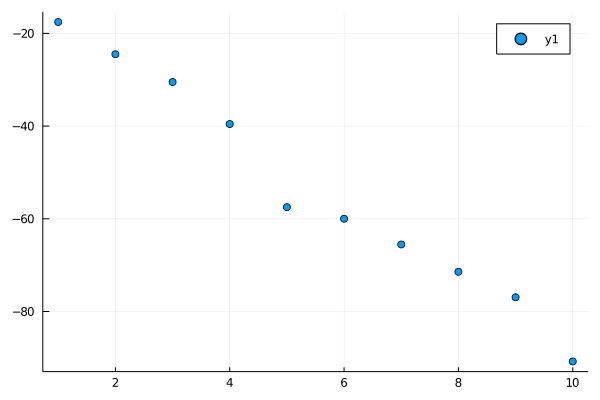

In [15]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [16]:
nev = 4
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [17]:
for i in 1:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

exact ev1: -17.89831647151497	 predicted ev1: -17.90543735760738	 relative error: 0.0003978522842492829
exact ev2: -25.012204377752006	 predicted ev2: -25.273440587753438	 relative error: 0.010444349728478847
exact ev3: -31.505825467705748	 predicted ev3: -30.34354242473746	 relative error: 0.03689105191545151
exact ev4: -42.408552782052155	 predicted ev4: -42.089796143662134	 relative error: 0.00751632907701869


In [18]:
color =    :balance
xticks =   -4:2:6
yticks =   -34:2:-28
colorbar = :left
cmins =     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,]
cmaxs =     -cmins
cmins_lr =  [-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,-0.2, -0.2, -0.2, -0.2,]
cmaxs_lr =  -cmins_lr;

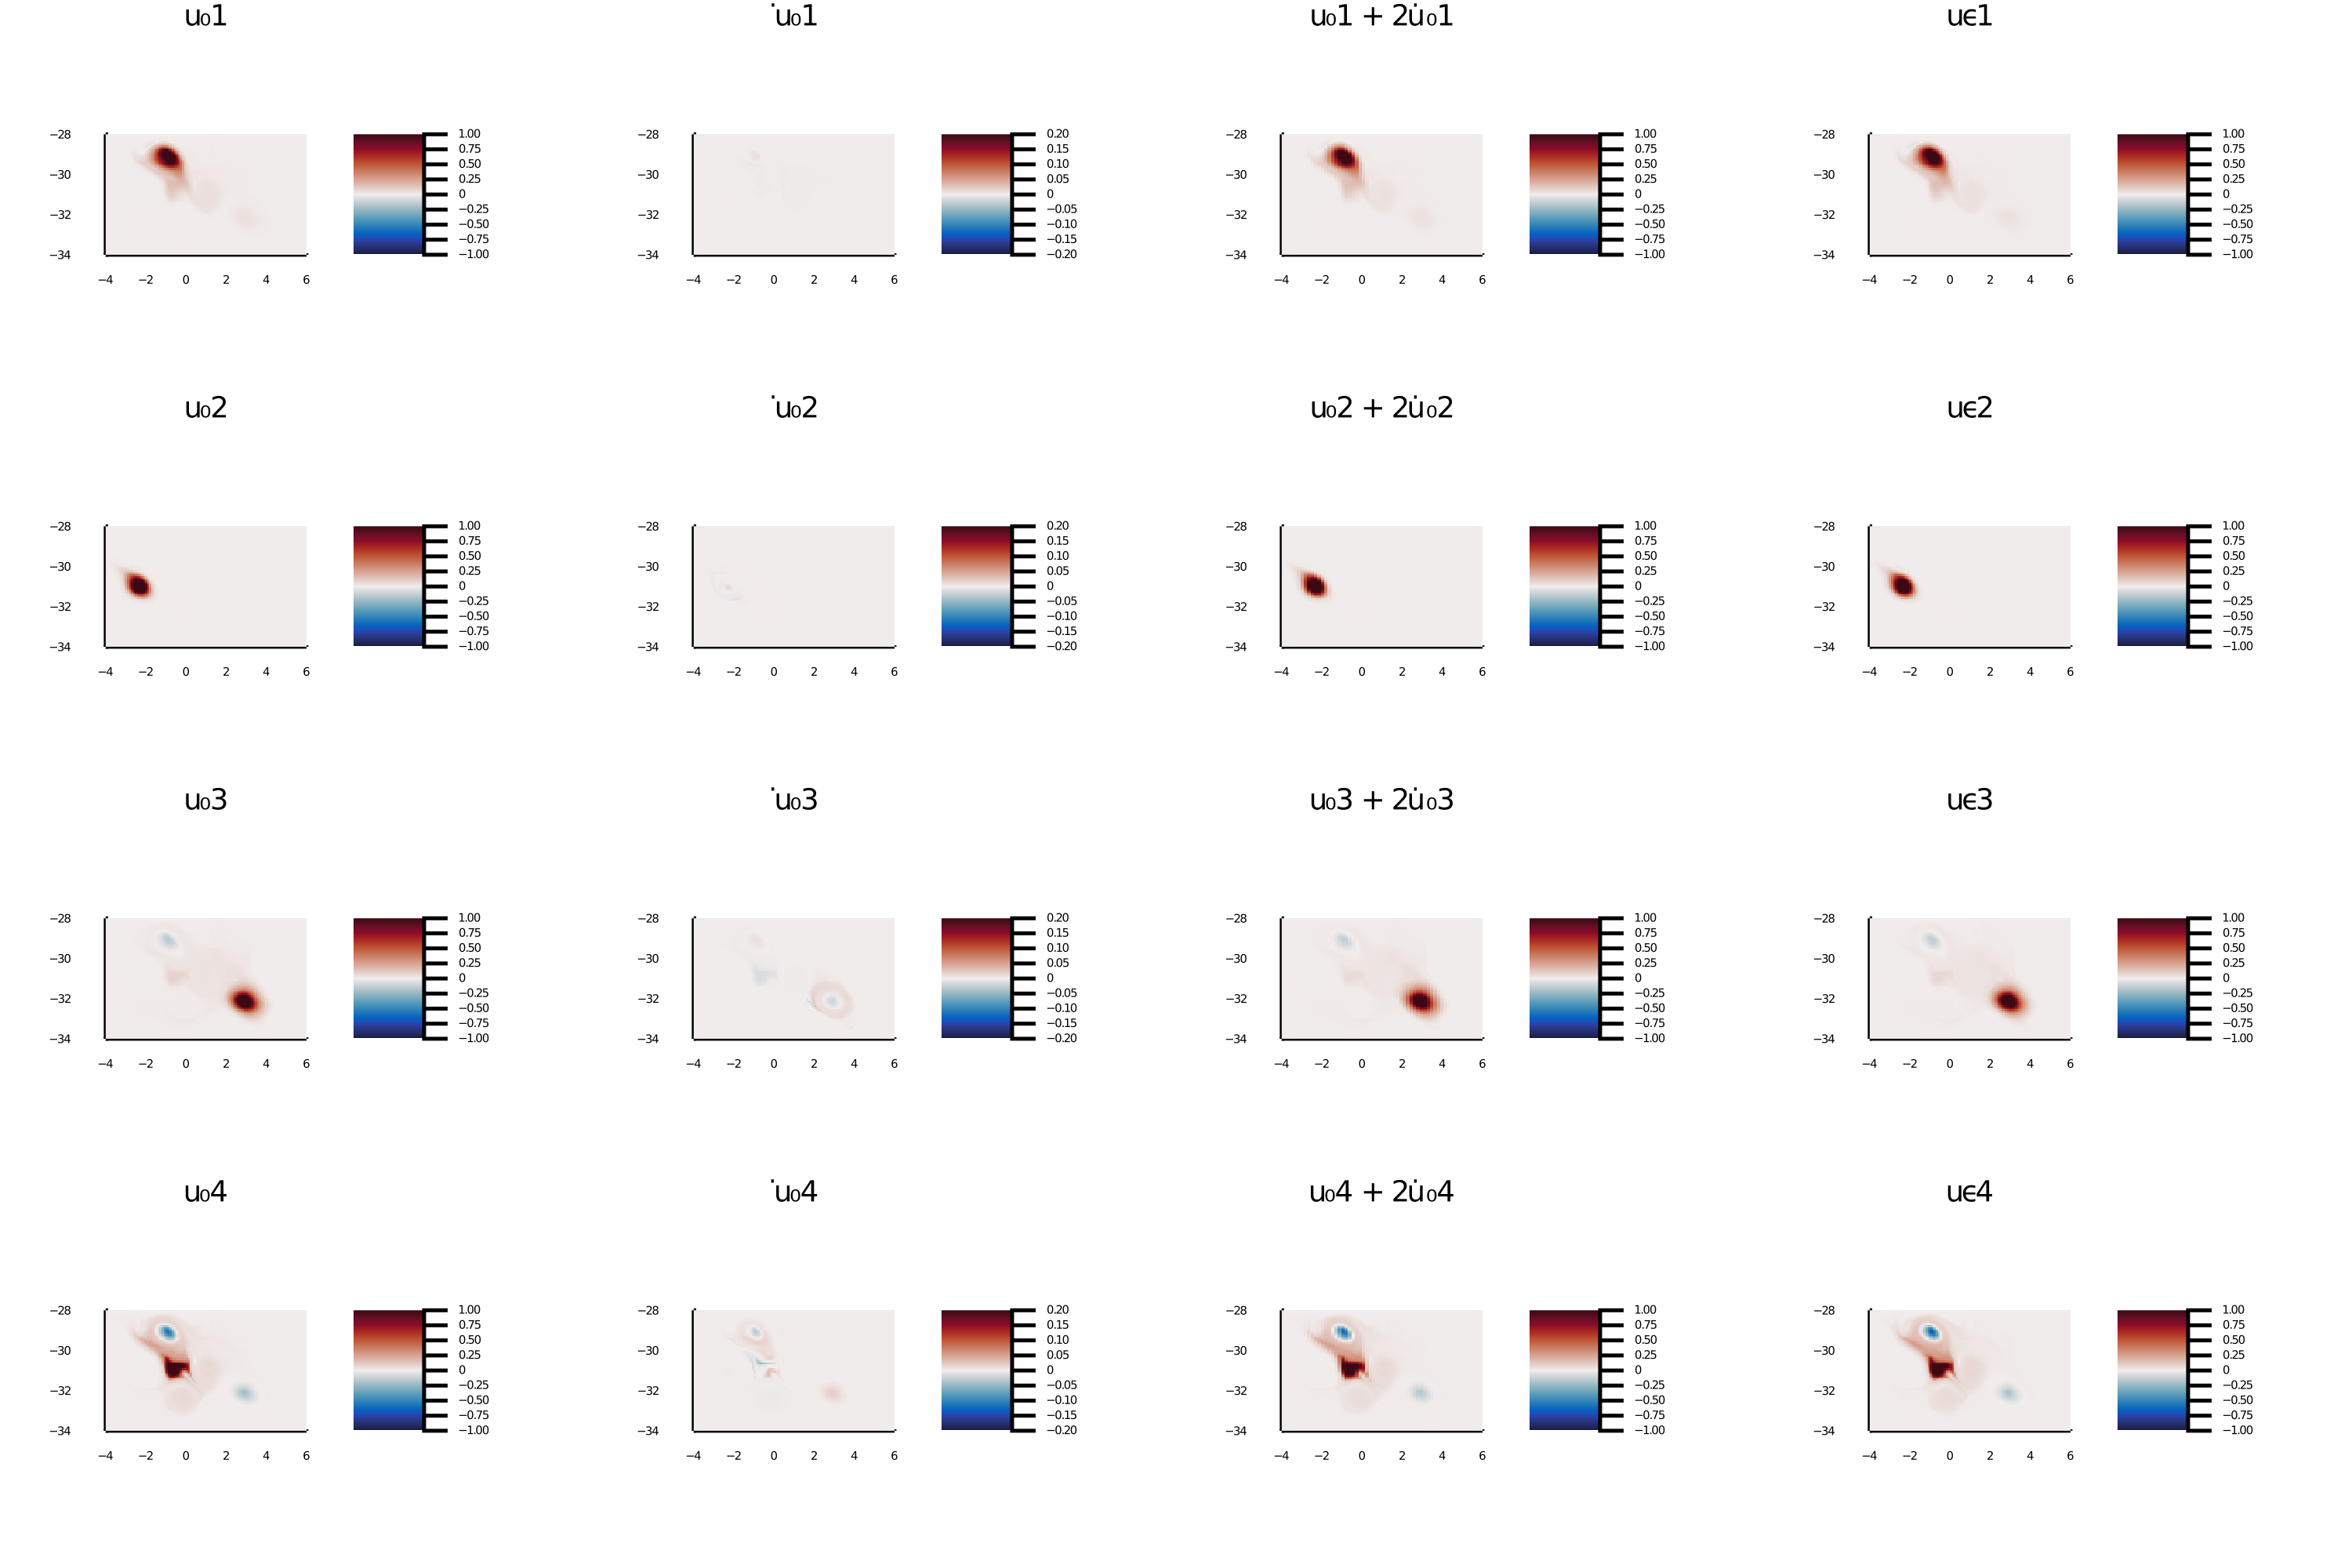

In [19]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  lat_resolution, grid_resolution, bdata=bdata,
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  lon_resolution, lat_resolution, bdata=bdata,
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [20]:
#limit ourselves to one ev for plotting etc.
ev = 1

1

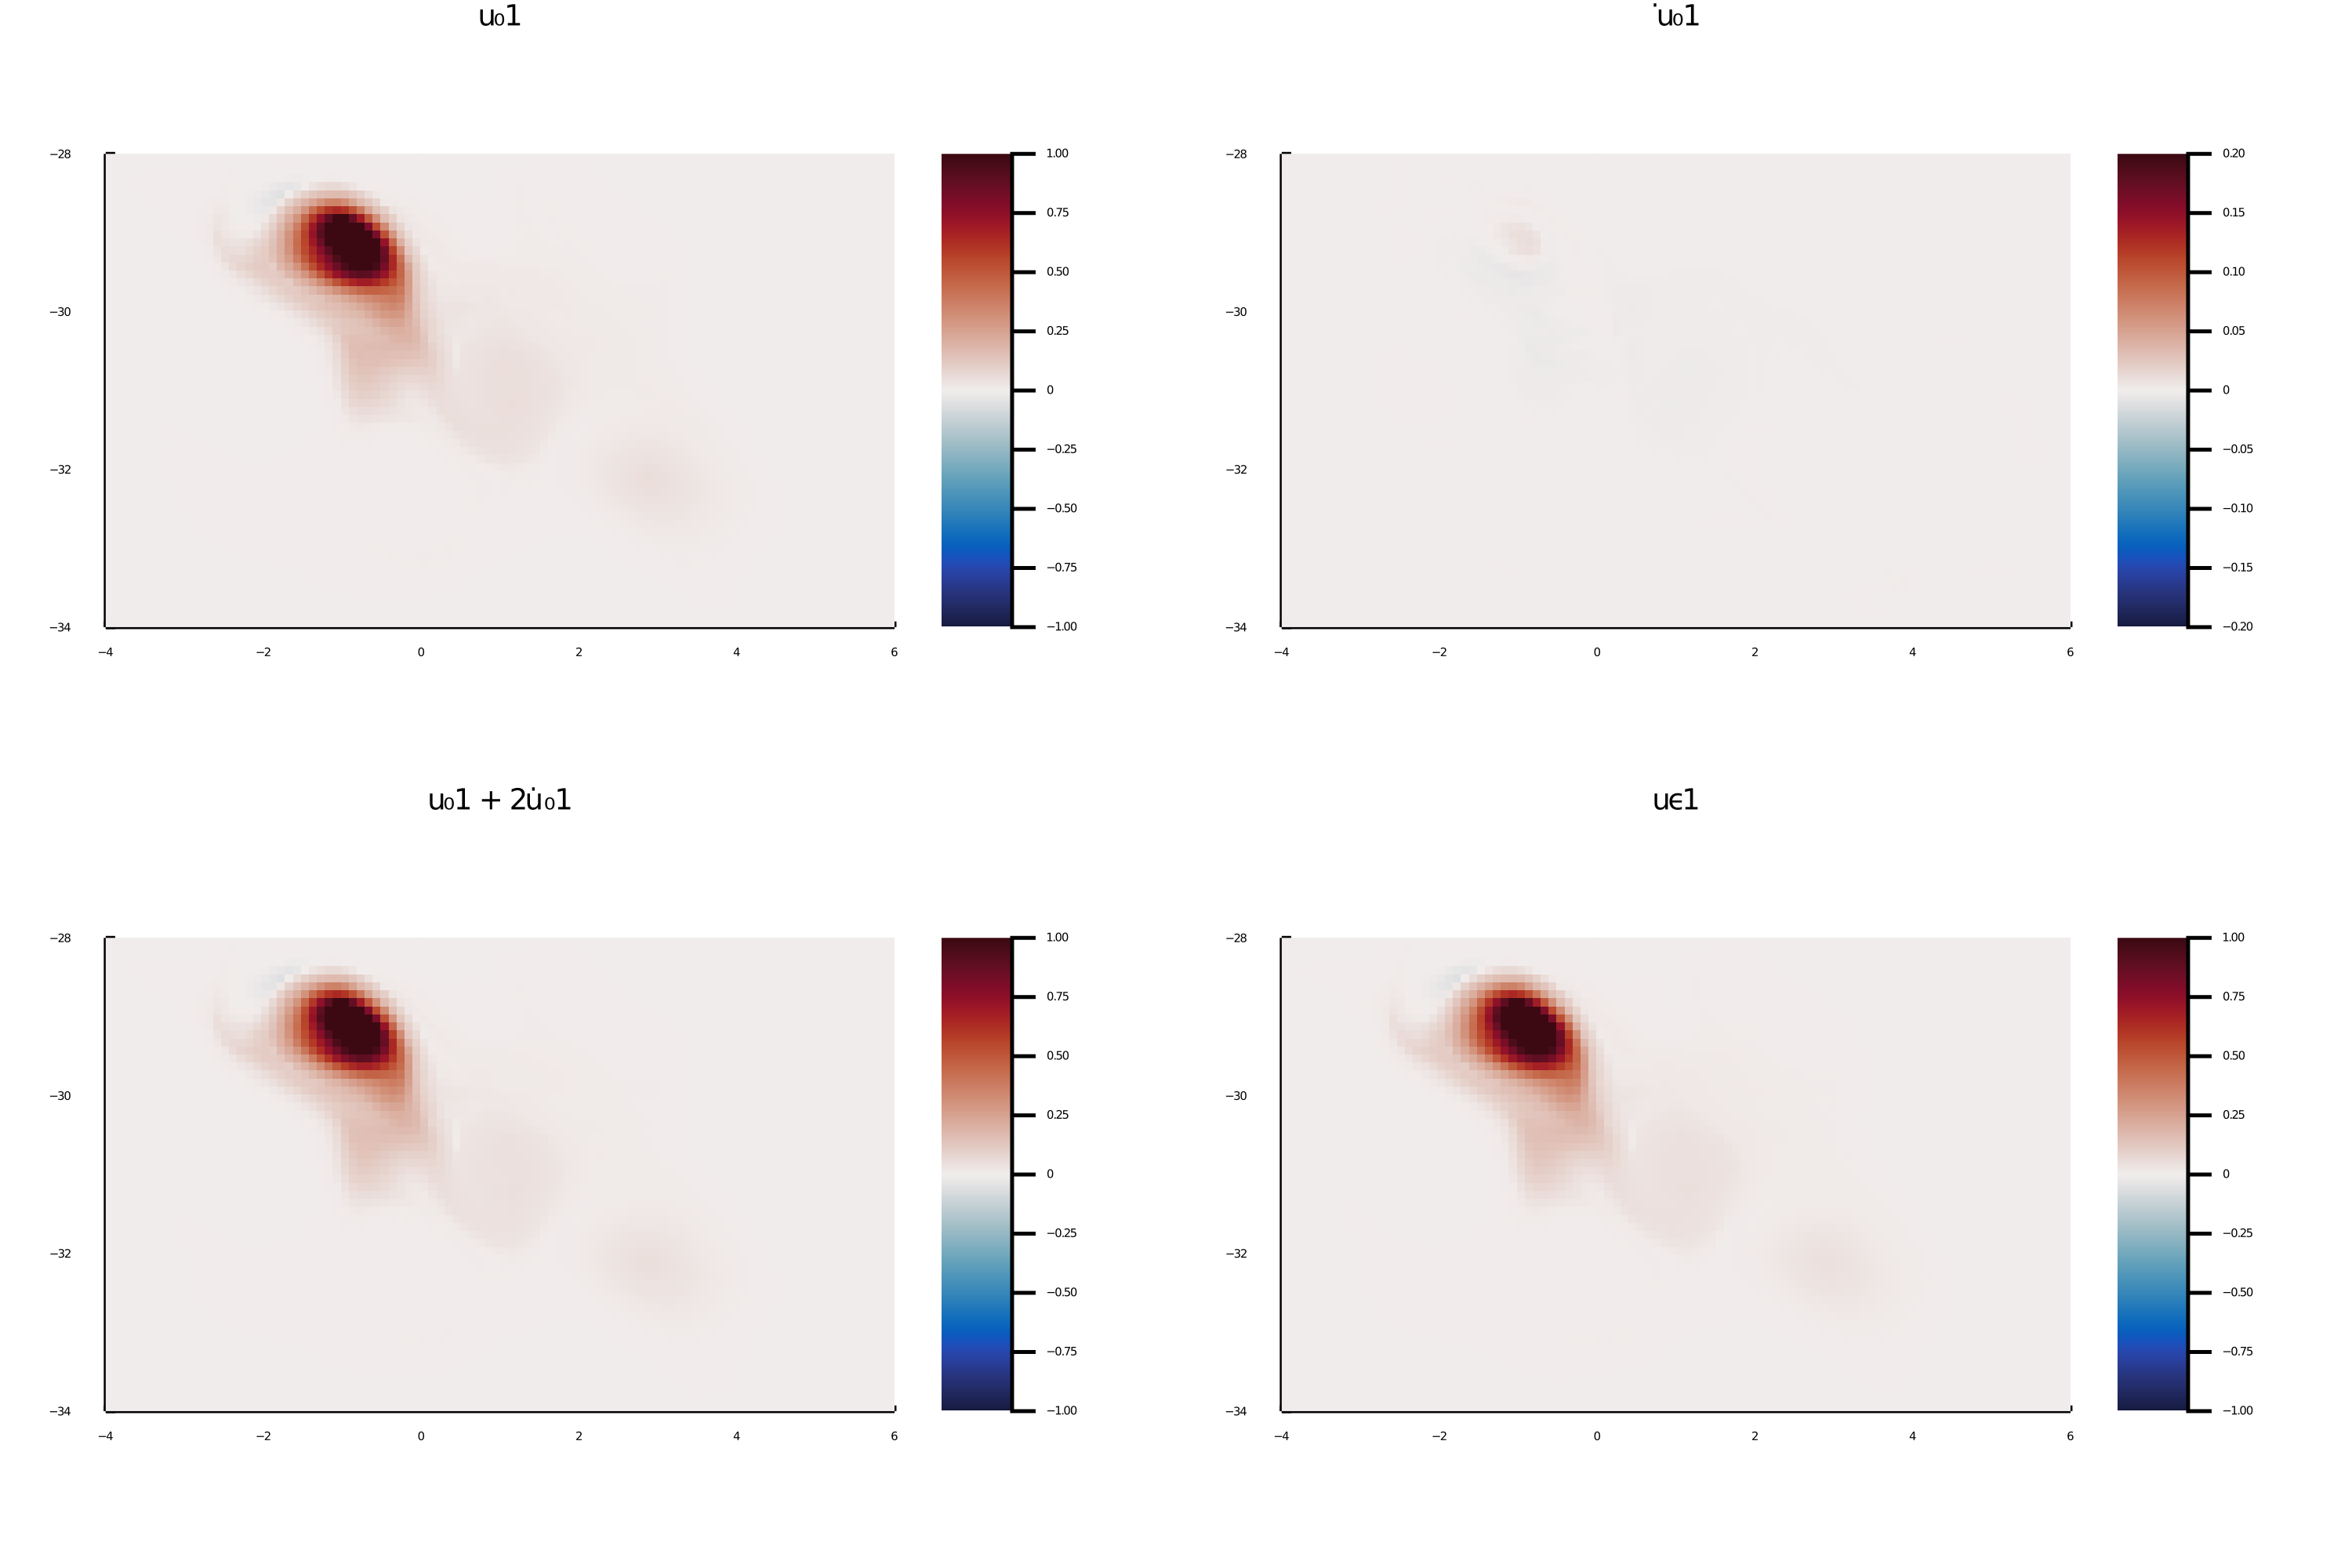

In [21]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [22]:
using Contour

In [23]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [24]:
# Just here to compare with the matlab function

function isClosed(curve)
   return Main.CoherentStructures.closeCurve(ctx,curve,tolerance=1e-10) == curve
end

function dynamic_cheeger_value_matlab(curve)
    image_curve   = Main.CoherentStructures.apply2curve(x->T(x,ϵ),curve)
    
    if !isClosed(curve) || !isClosed(image_curve)
        return Inf
    end
    
    return 0.5(Main.CoherentStructures.getLength(curve)/Main.CoherentStructures.getEuclideanArea(ctx,curve,tolerance=1e-10) +
        Main.CoherentStructures.getLength(image_curve)/Main.CoherentStructures.getEuclideanArea(ctx,image_curve,tolerance=1e-10))
end

dynamic_cheeger_value_matlab (generic function with 1 method)

In [25]:
# resoultion for the levelset methods (default should be 'nothing', that way the grid resolution is used)
x_resolution = 500
y_resolution = Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*x_resolution));

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03282946945596714)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.03128973739051851)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.02975000532506989)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.008193756408789166)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0066540243433405415)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.005114292277891918)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0035745602124432952)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.002034828146994672)
└ @ Main In[26]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ",

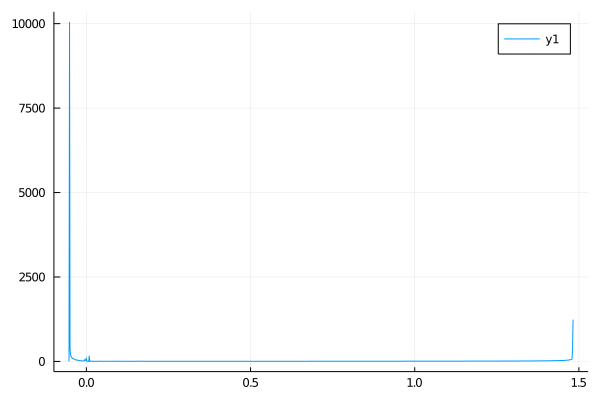

In [26]:
minU = minimum(u₀[:,ev])
maxU = maximum(u₀[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0003003003003003003)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0006006006006006006)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0009009009009009009)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0012012012012012011)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0015015015015015015)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0018018018018018018)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002102102102102102)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002402402402402

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023423423423423424)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023723723723723725)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.024024024024024024)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.024324324324324326)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.024624624624624624)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.024924924924924926)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.025225225225225224)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.025525525525525526)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0258

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04504504504504504)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.045345345345345345)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04564564564564565)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04594594594594595)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04624624624624624)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.046546546546546545)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04684684684684685)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.04714714714714715)
└ @ Main In[27]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0474474474

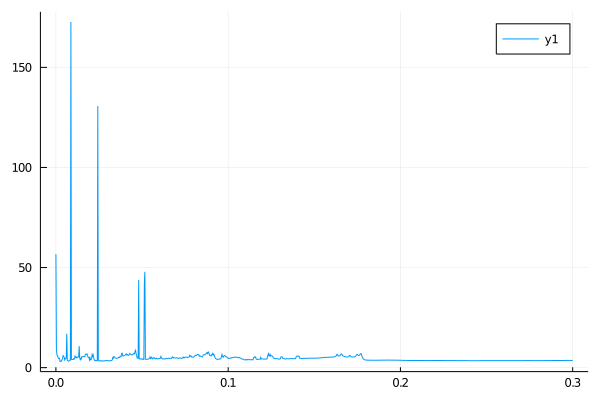

In [27]:
minU = 0
maxU = 0.3
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[1:end],values[1:end])
Plots.plot!(fmt=:png,dpi=100)

In [28]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0014852919069178446)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.002970583813835689)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.004455875720753534)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: (

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.10842630920500267)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.1099116011119205)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11139689301883834)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.11288218492575619)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌

Dynamic Cheeger value:	

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 1.4808360311970912)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 1.4823213231040089)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


3.1722544013684812
Levelset:		0.002970583813835689


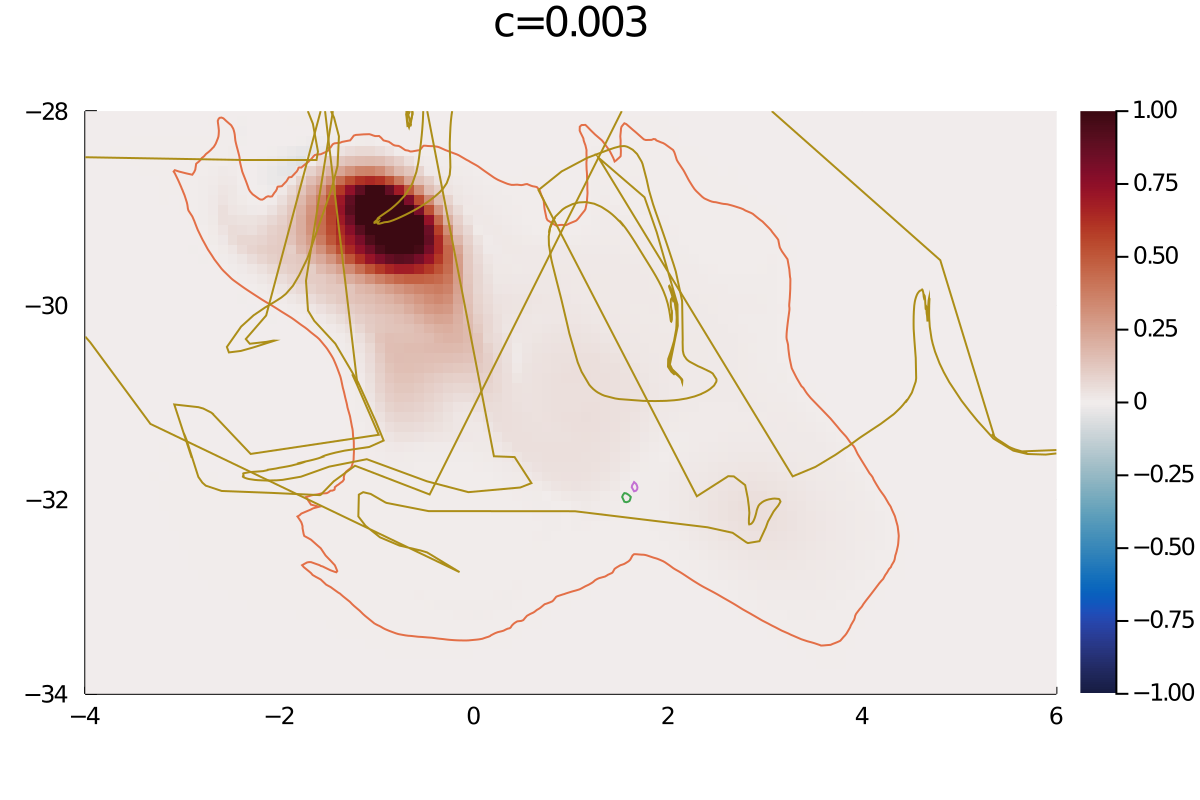

In [29]:
c_best = level(best_levelset)
plot_u(ctx, u₀[:,ev],  lon_resolution, lat_resolution, title="c=$(round(c_best,digits=4))", bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

In [30]:
using PyCall
using PyPlot

In [31]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

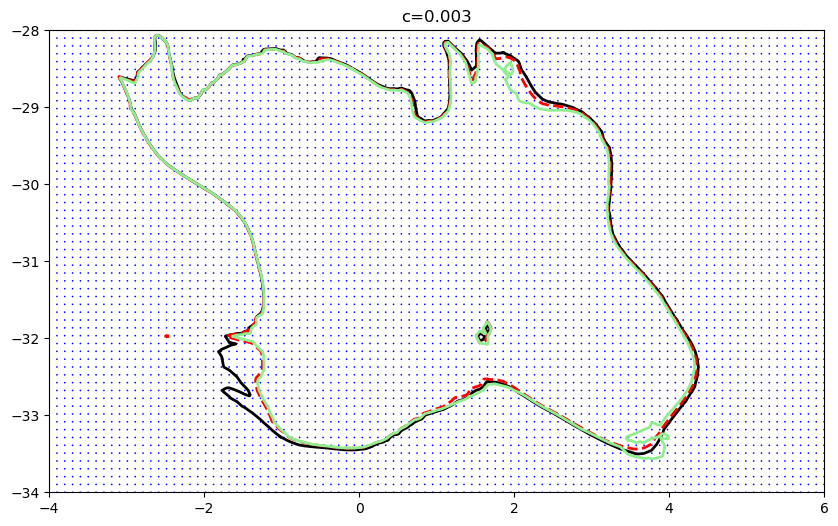

In [32]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev],bdata=bdata)...,ax,scale=5,step=1)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");

## SEBA

In [33]:
using LinearAlgebra

In [34]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))
normalizeU(u,v) = u.*sign.(sum(v))/maximum(v*sign.(sum(v)));

In [35]:
μ = 0.99/grid_resolution;

In [36]:
@time S, R = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.462096 seconds (6.33 M allocations: 340.464 MiB, 5.73% gc time)


In [37]:
order = sortperm([-minimum(S[:,i]) for i in 1:nev]);

In [38]:
# This is the matrix we effectively multiply u₀ with
Rot = inv(qr(u₀).R)*R'

4×4 Array{Float64,2}:
 -0.0998806   -1.05177e-5  -0.00465434  -0.0125263
 -1.32423e-5   0.100514    -1.32132e-5   2.32103e-5
  0.00570656  -9.27928e-6  -0.100162    -0.00903481
  0.0116382    2.97398e-5   0.00962093  -0.0991156

In [39]:
S_dot = u_dot*Rot;

In [40]:
Sϵ, Rϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [41]:
S′ = Matrix(qr(u₀).Q)*R';

In [42]:
Sϵ′ = Matrix(qr(uϵ).Q)*Rϵ';

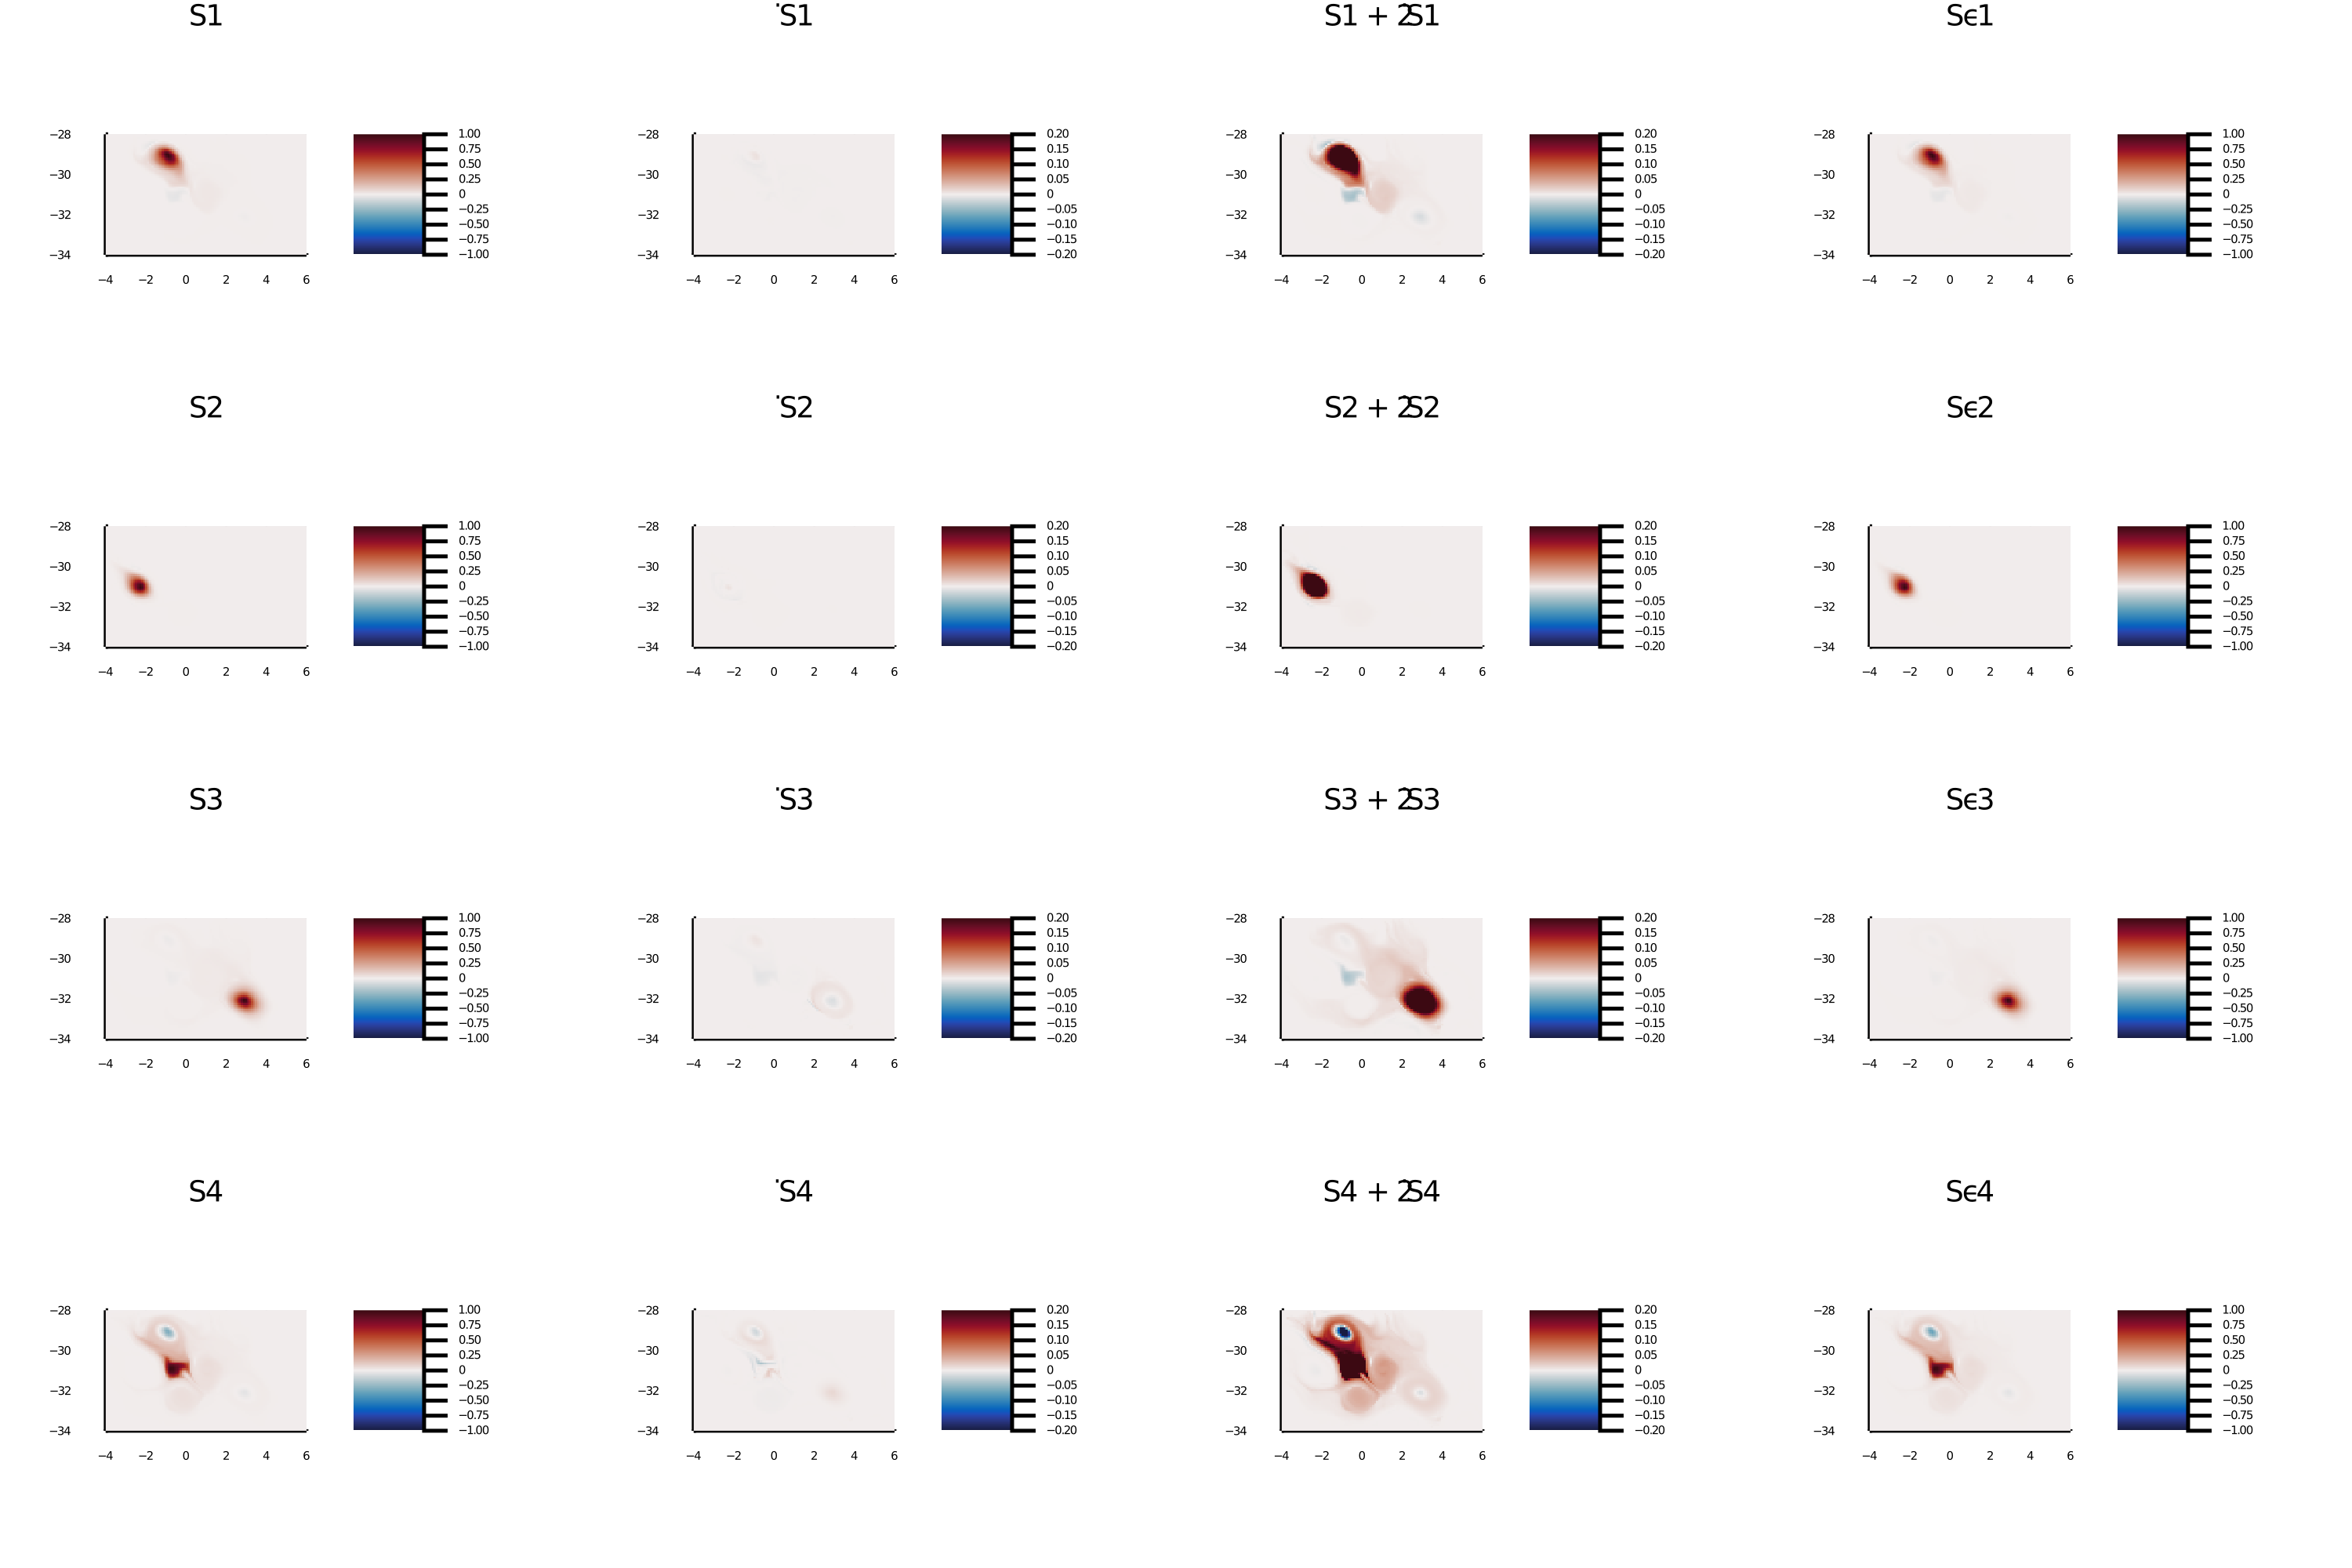

In [43]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, normalizeU(S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S′[:,i] + ϵ*S_dot[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

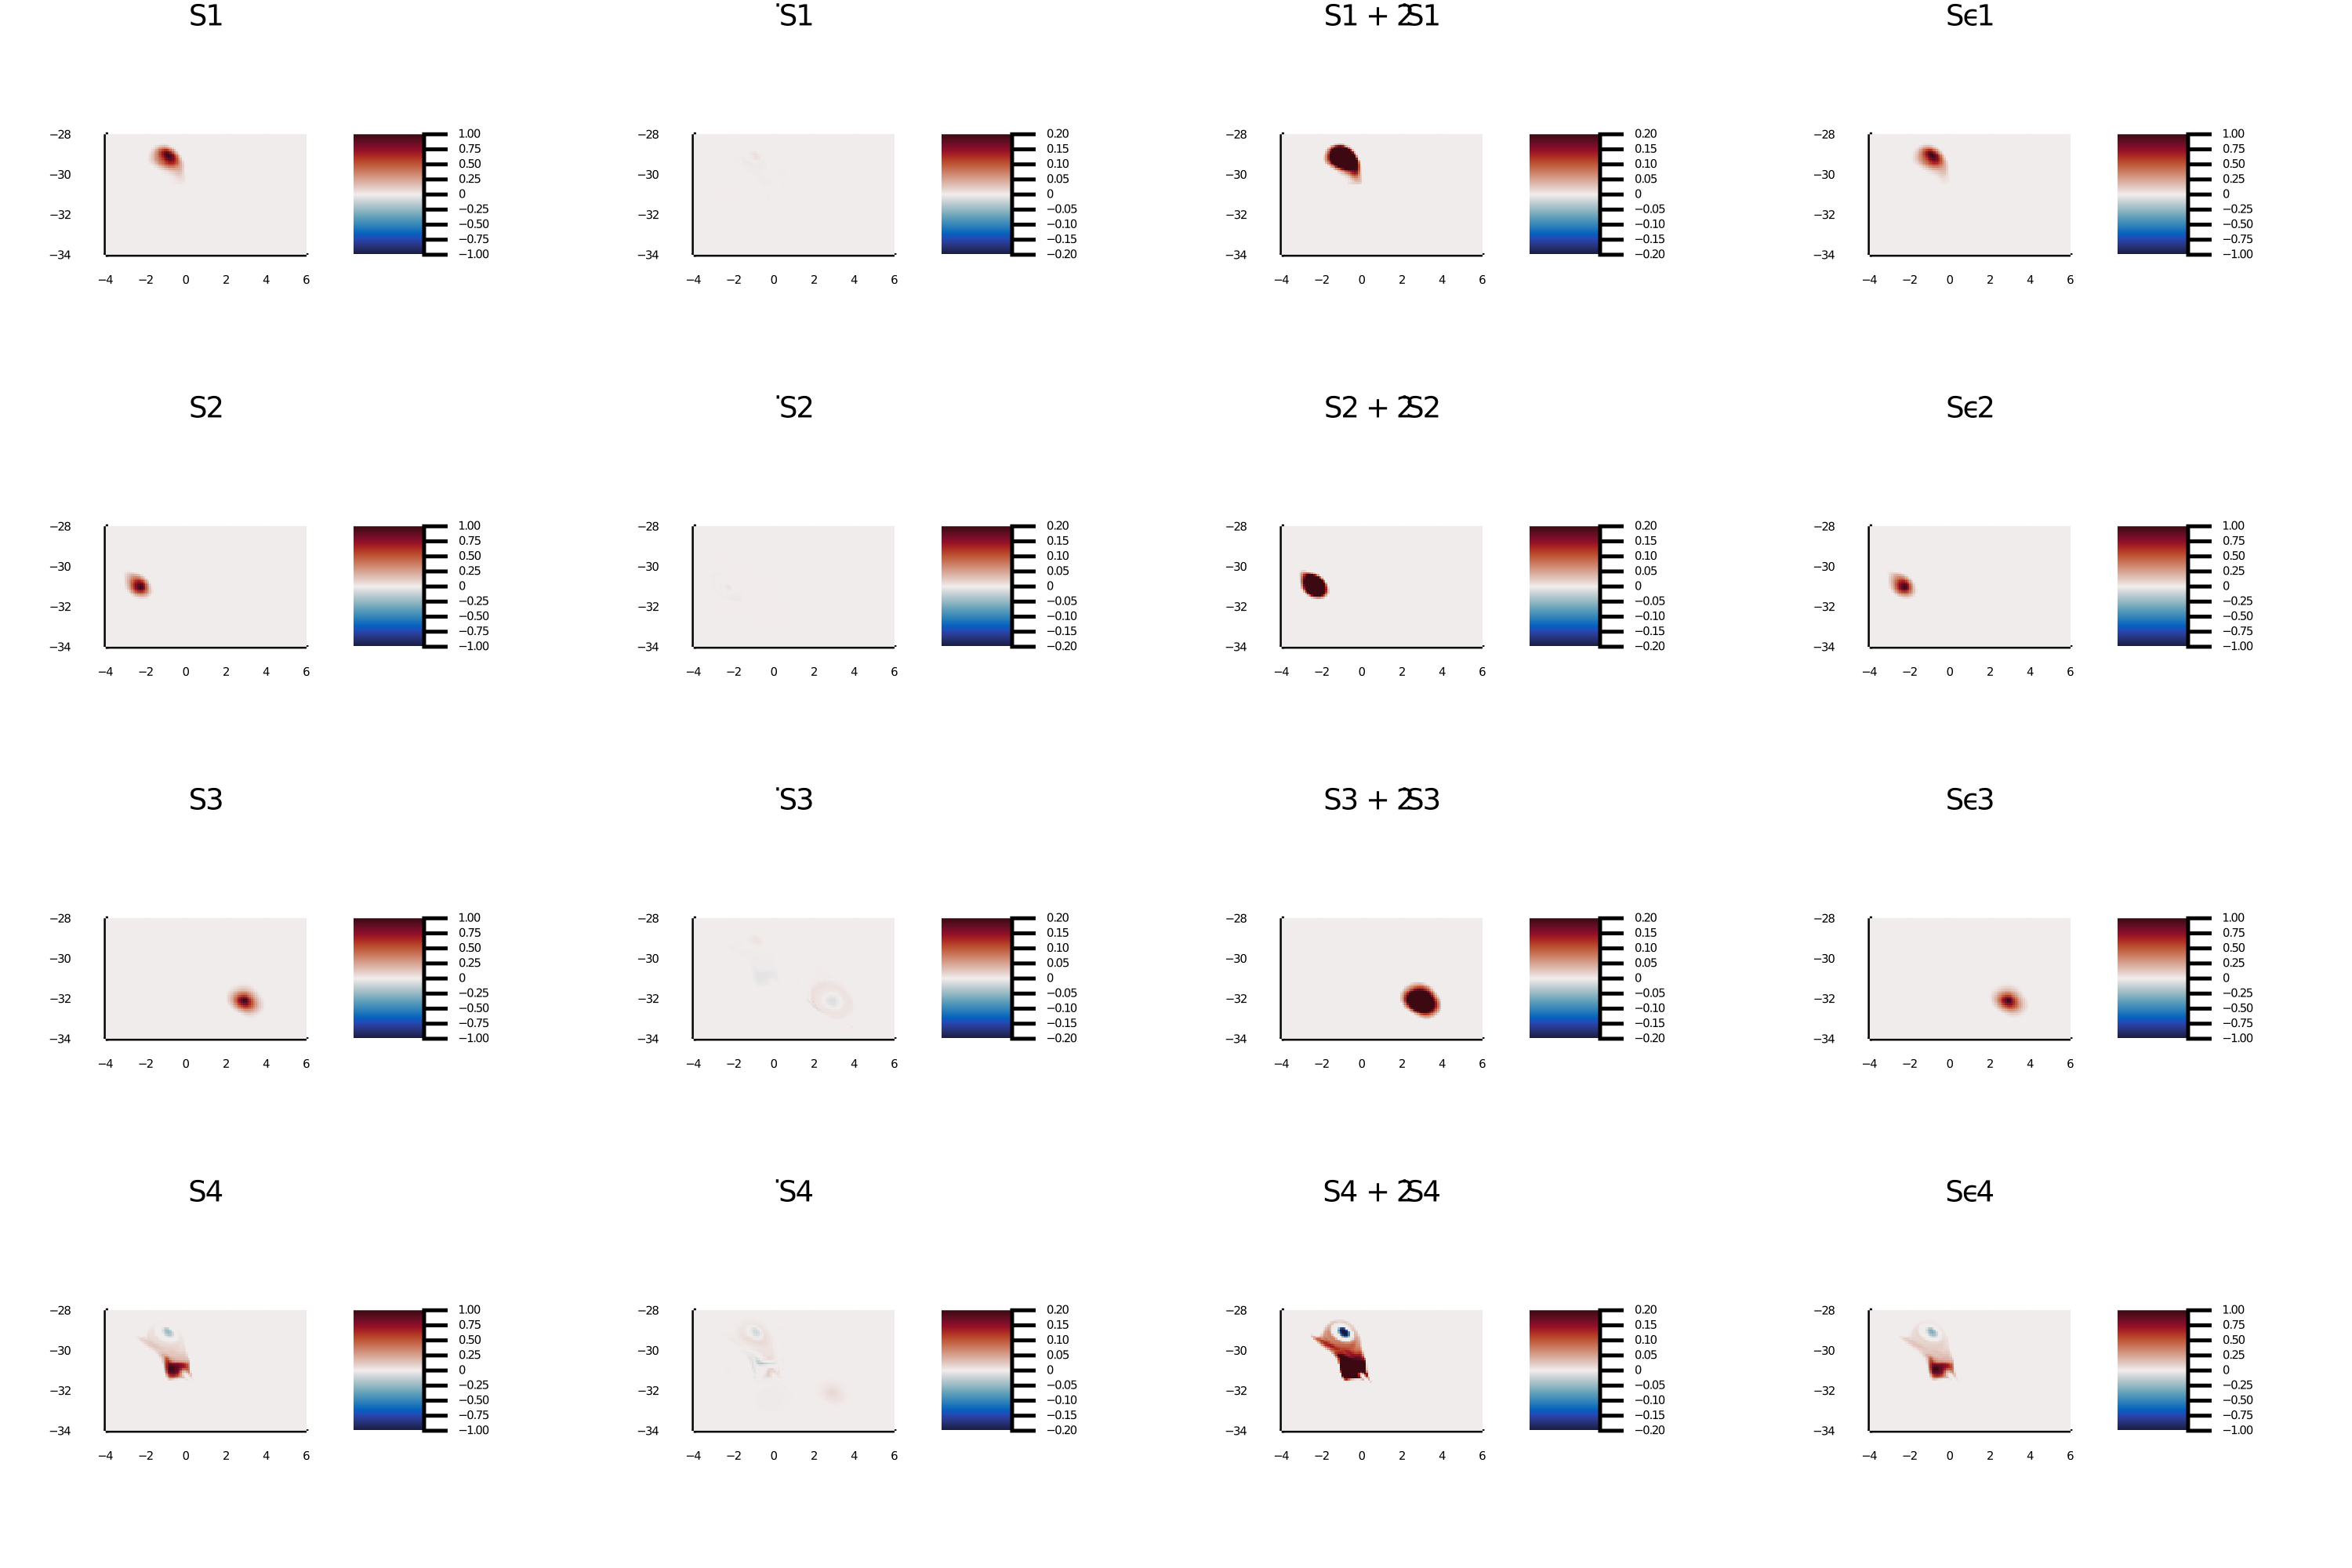

In [44]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(S_dot[:,i],S′[:,i]),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            lon_resolution, lat_resolution, bdata=bdata,
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            lon_resolution, lat_resolution, bdata=bdata,
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

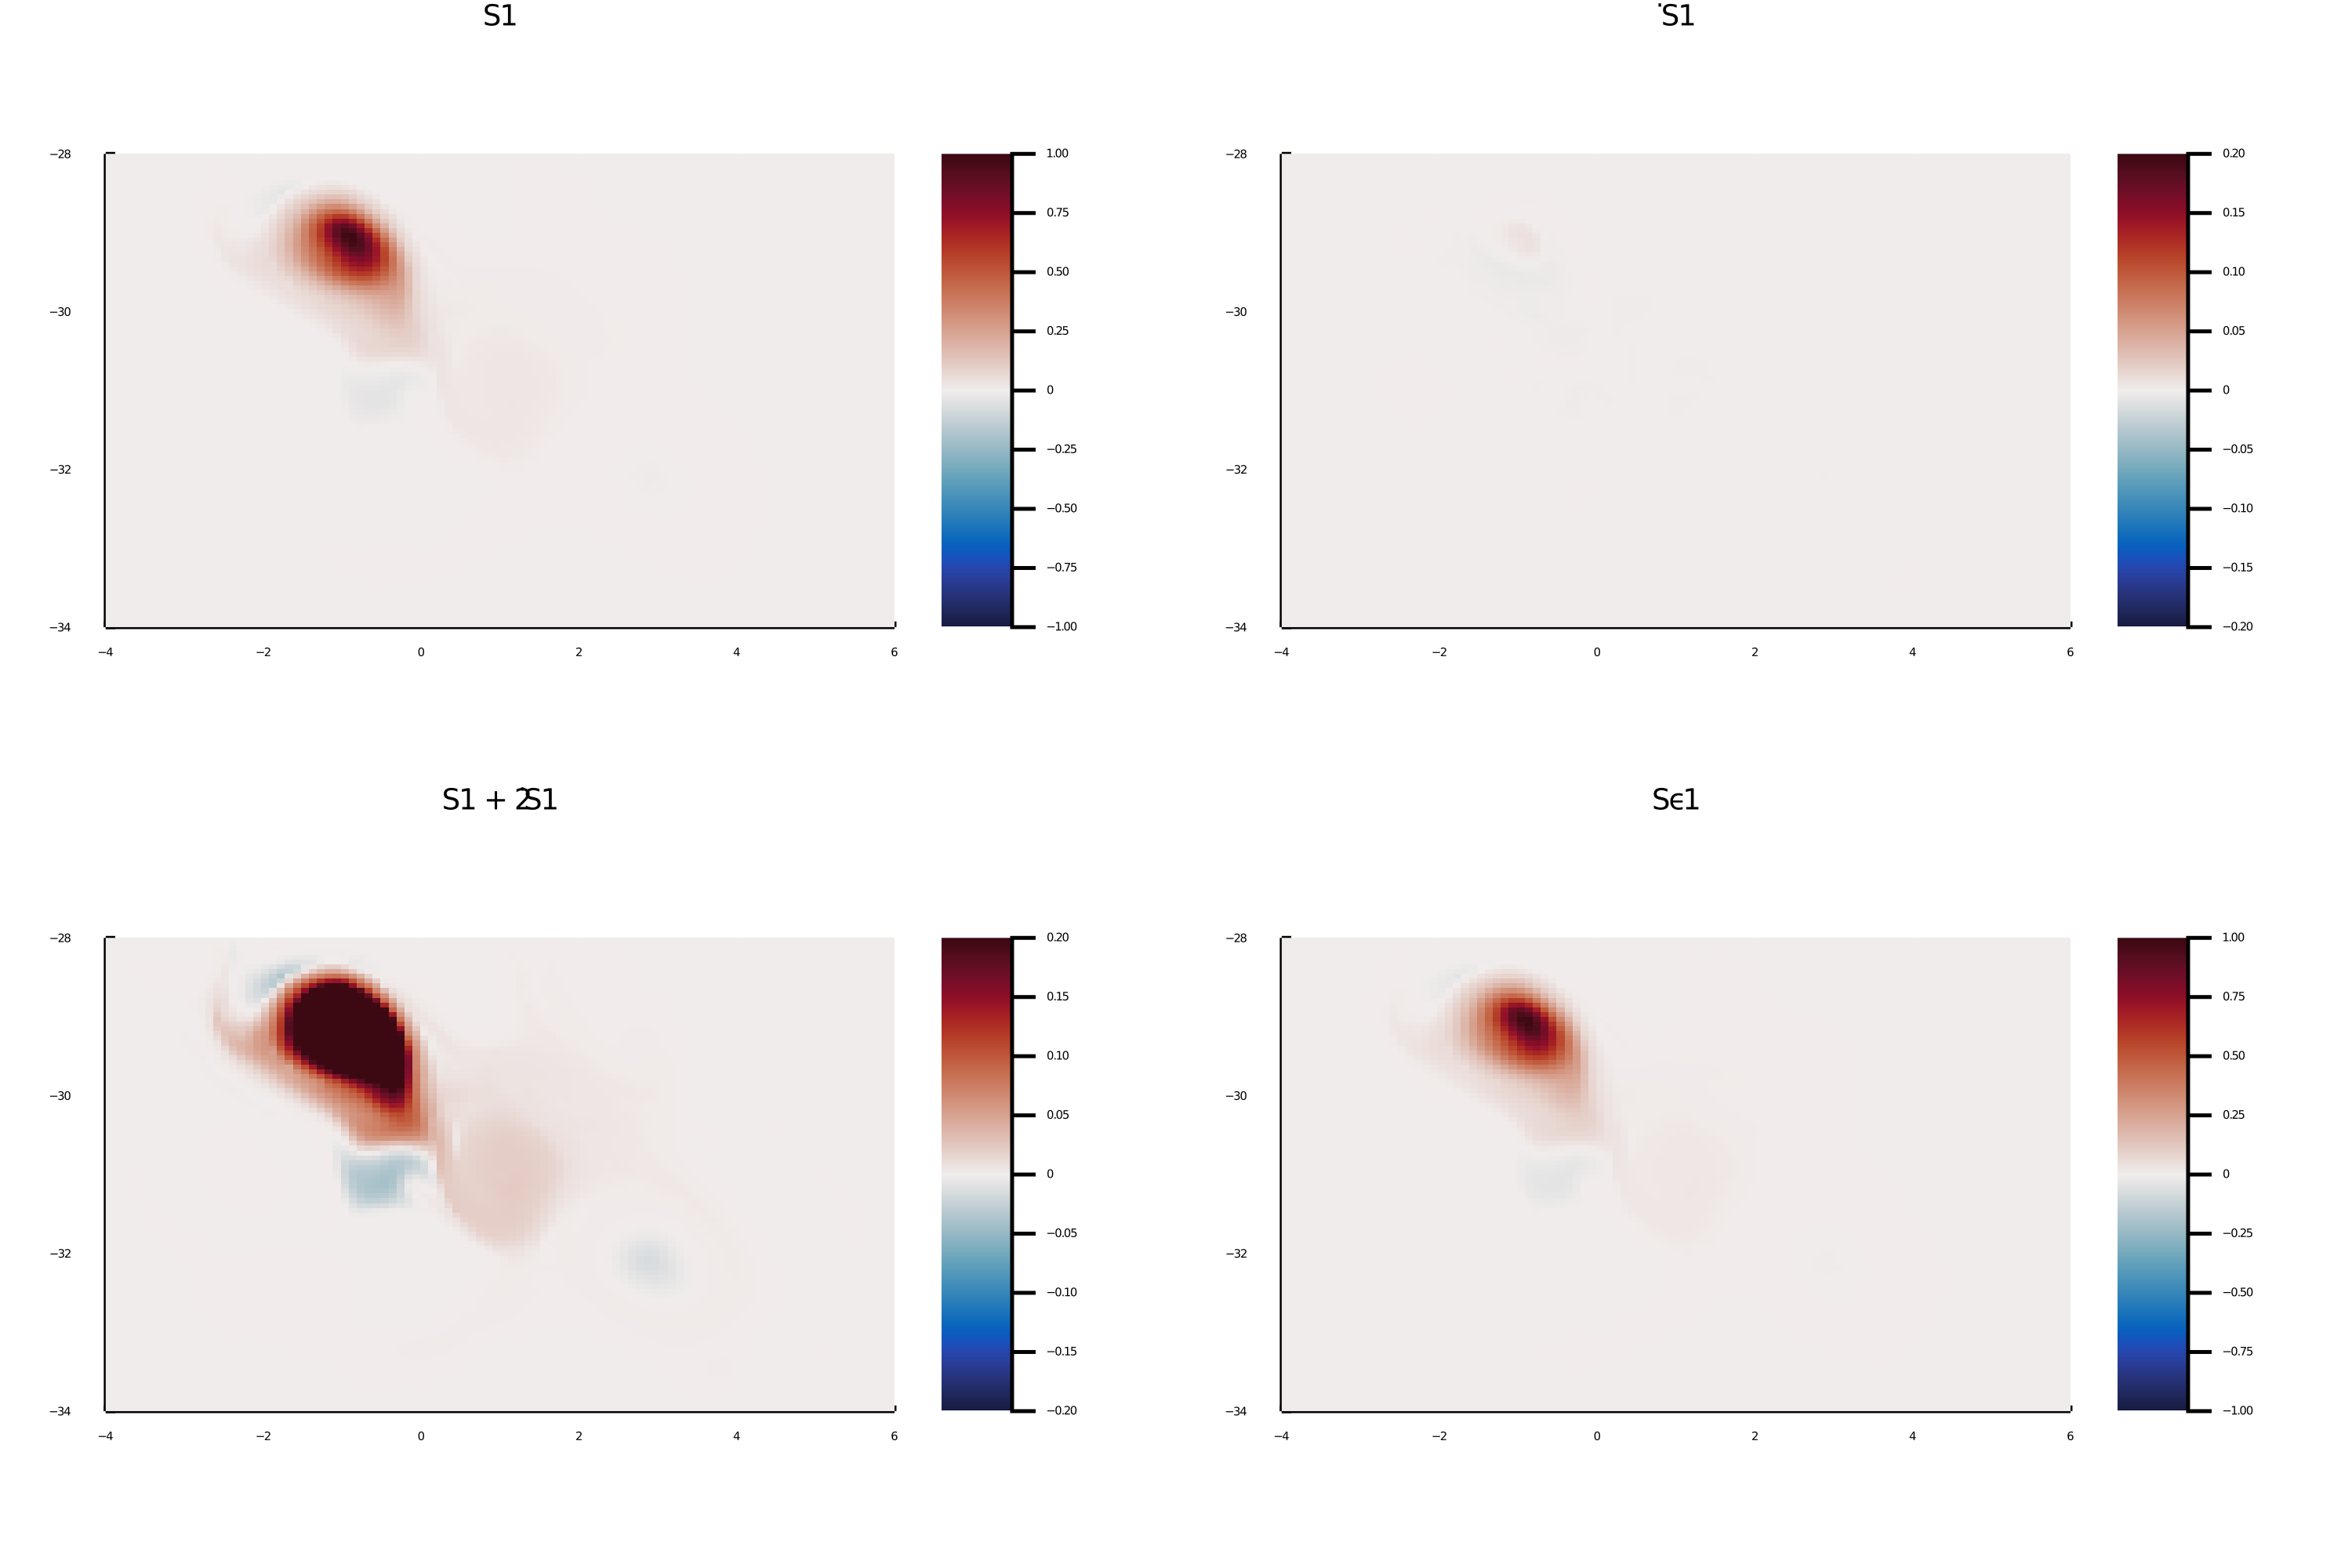

In [45]:
plots = []
push!(plots,plot_u(ctx, normalizeU(S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S′[:,ev] + ϵ*S_dot[:,ev]),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(Sϵ′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

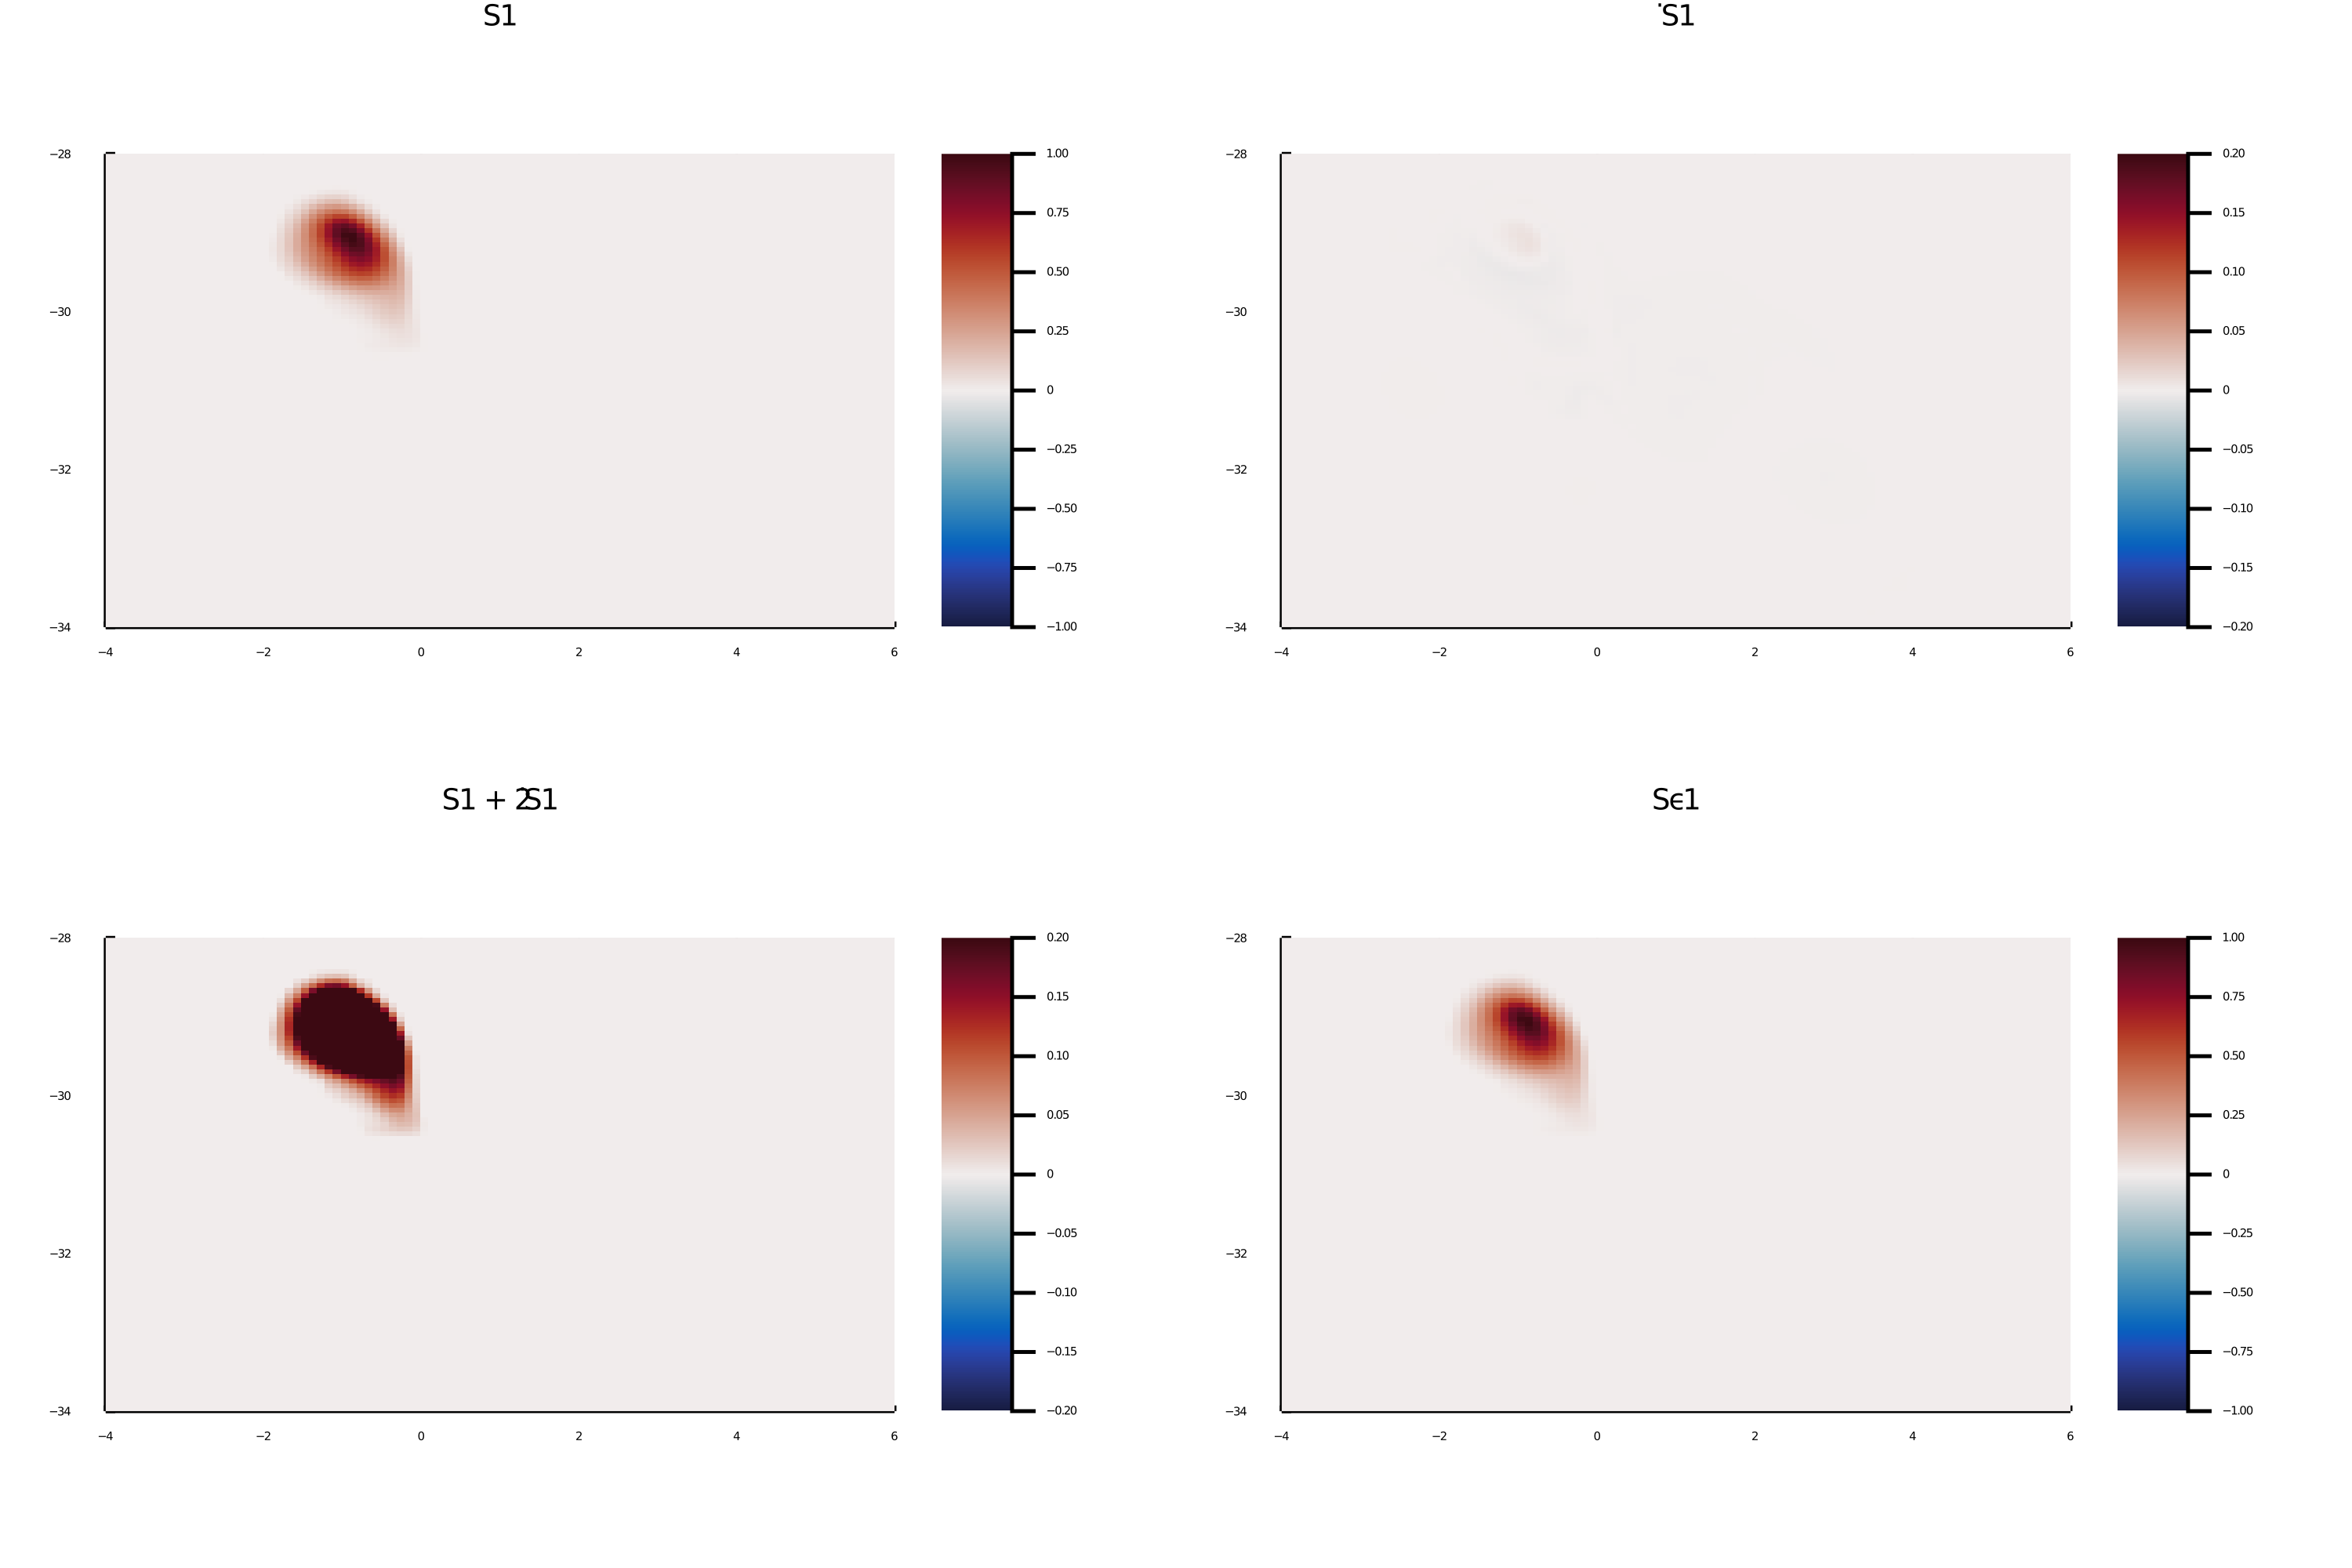

In [46]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(S_dot[:,ev],S′[:,ev]),  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.996996996996997)
└ @ Main In[47]:10
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.997997997997998)
└ @ Main In[47]:10


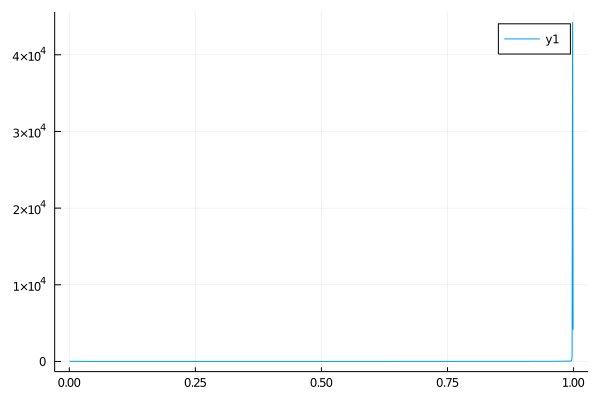

In [47]:
minU = minimum(S[:,ev])
maxU = maximum(S[:,ev])
values = []
for c in range(minU,stop=maxU,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,S[:,ev],c,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata)
    curves = lines(levelset)
    if (length(curves)>0)
        if length(curves) != 1
            @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
        end
        push!(values,dynamic_cheeger_value(curves[1]))
    else 
        push!(values,0)
    end
end
Plots.plot(range(minU,stop=maxU,length=1000)[2:end-1],values[2:end-1])
Plots.plot!(fmt=:png,dpi=100)

In [48]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata,
    n_candidates=1000,min=0)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

Dynamic Cheeger value:	3.4794345412458796
Levelset:		0.08308308308308308


┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.996996996996997)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.997997997997998)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


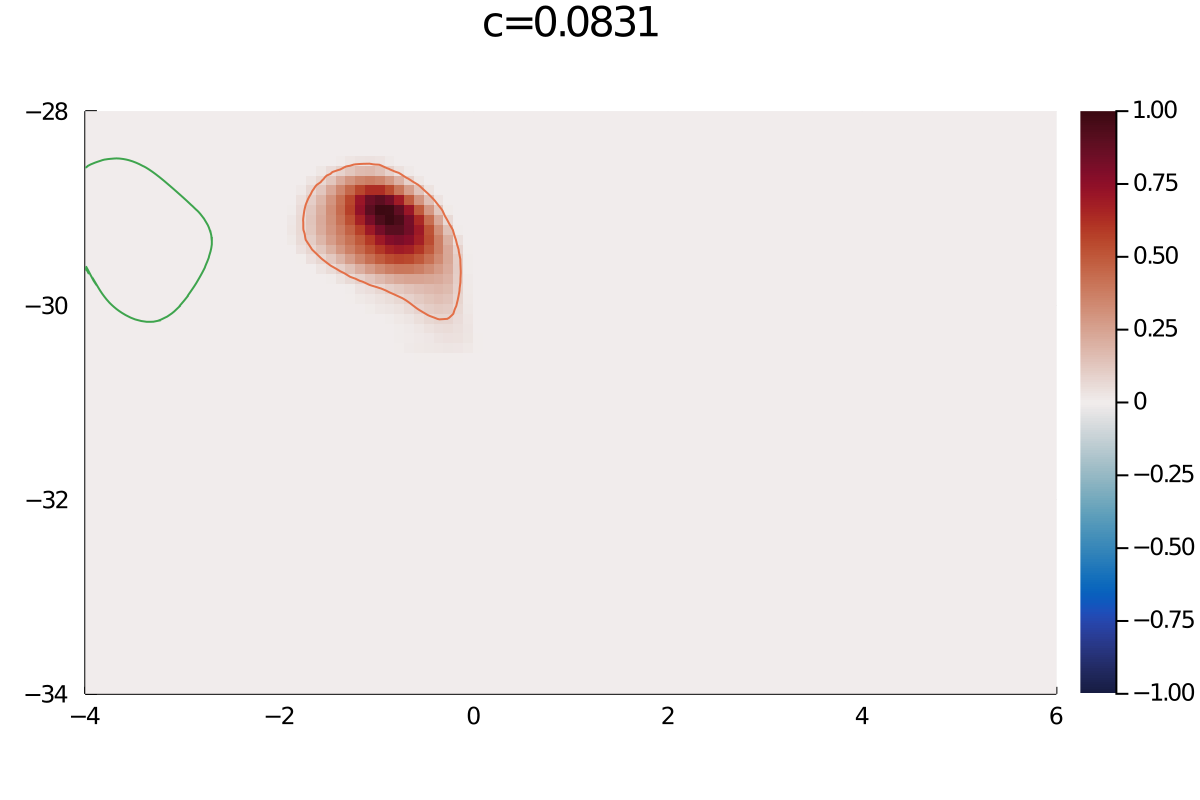

In [49]:
c_best = level(best_levelset)
plot_u(ctx, S[:,ev],  lon_resolution, lat_resolution, bdata=bdata,
        title="c=$(round(c_best,digits=4))",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks,legend=false)

curves = lines(best_levelset)
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value_matlab(curves[1])

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot!(fmt=:png,dpi=200,legend=false)

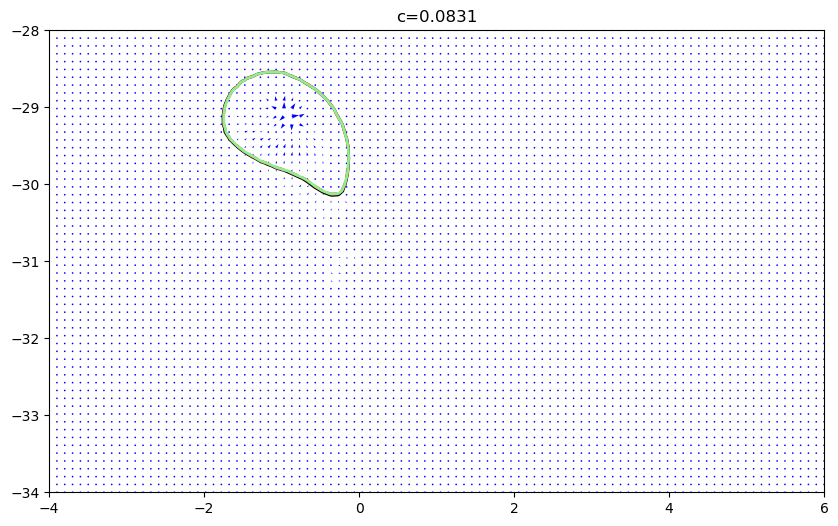

In [50]:
plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes()
ax.set(xlim=(-4,6), ylim=(-34,-28))
# this is not completely straightforward due to the nonlinearity of softThreshold!
plot_vectorfield(get_levelset_evolution(ctx,S′[:,ev],S_dot[:,ev],bdata=bdata)...,ax,scale=0.15,step=1)
curves           = lines(get_levelset(ctx, S[:,ev],c_best,
        x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),c_best,
                x_resolution=x_resolution,y_resolution=y_resolution,bdata=bdata))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_best,digits=4))");